# Lecture 6: Decision Theory — Loss, Risk, Admissibility, and Optimality

**Data 145, Spring 2026: Evidence and Uncertainty**  
**Instructors:** Ani Adhikari, William Fithian

---

**Please run the setup cell below before reading.**

---

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('fivethirtyeight')
%matplotlib inline

# Color scheme for this lecture (colorblind-safe palette)
# Using IBM's colorblind-safe palette
COLOR_MLE = '#648FFF'       # Blue - MLE (unbiased)
COLOR_LAPLACE1 = '#785EF0'  # Purple - Laplace +1/+1
COLOR_LAPLACE2 = '#DC267F'  # Magenta - Laplace +2/+2  
COLOR_BAD = '#FE6100'       # Orange - Inadmissible
COLOR_TRUE = '#000000'      # Black - True value

## Introduction: A Coin Flip Experiment

In Lectures 3–5, we developed the theory of maximum likelihood estimation. We showed that the MLE is:
- **Consistent**: $\hat{\theta}_n \stackrel{P}{\to} \theta_0$
- **Asymptotically normal**: $\sqrt{n}(\hat{\theta}_n - \theta_0) \stackrel{d}{\to} N(0, 1/I(\theta_0))$
- **Efficient**: Among unbiased estimators, it achieves the Cramér-Rao lower bound

This is a powerful result: if you want an unbiased estimator with small variance, the MLE is (asymptotically) the best you can do. But do we really need to be unbiased?

### The Demo

*In lecture, we flip a coin 16 times and count heads. Let's say we observe $X$ heads.*

If $X \ne 8$, the MLE $\hat{p} = X/16$ is different from 0.5. But most coins are pretty close to fair. If we suspect the true $p$ is close to 0.5, should we *shrink* our estimate toward 0.5?



Could a biased estimator that shrinks toward 0.5 actually be *better* in some sense? To answer this, we need to be precise about what "better" means. As mathematicians, we want to do this at a higher level of abstraction — so we can say interesting things about many different estimation problems, not just this coin.

Today we'll see that:
1. Biased estimators can sometimes have *lower* mean squared error than the MLE
2. There's no single "best" estimator — different estimators are optimal under different criteria
3. This leads naturally to **Bayesian statistics** as one principled way to choose among estimators

---

## 1. Decision Theory in Statistical Estimation

### The Setup

Recall our standard setup:
- **Data**: $X$ (often $X_1, \ldots, X_n$ i.i.d.)
- **Model**: $f_\theta$ indexed by parameter $\theta \in \Theta$
- **Estimand**: Some function $g(\theta)$ we want to estimate (often just $\theta$ itself)
- **Estimator**: A function $T(X)$ that produces our estimate

When estimating $\theta$ itself, we typically write $\hat{\theta}(X)$ or just $\hat{\theta}$.

### Loss Functions

A **loss function** $L(\theta, a)$ measures how bad it is to report the estimate $a$ when the true parameter is $\theta$.

**Squared error loss** is the most common choice:
$$L(\theta, a) = (\theta - a)^2$$

Other loss functions exist (absolute error, 0-1 loss, etc.), but we'll focus on squared error.

### Risk Functions

The loss for a single dataset doesn't tell us much — one estimator might beat another by luck. We want to average over the sampling distribution.

The **risk function** is the expected loss:
$$R(\theta; T) = E_\theta[L(\theta, T(X))]$$

We write $R(\theta; T)$ with a semicolon because the risk is primarily a function of $\theta$; the estimator $T$ is fixed.

For squared error loss, this is the **mean squared error (MSE)**:
$$R(\theta; T) = \text{MSE}_\theta(T) = E_\theta[(T(X) - \theta)^2]$$

### The Fundamental Problem

The risk function depends on $\theta$, which we don't know! Different estimators may be better for different values of $\theta$.

This creates a fundamental tension: **how do we compare estimators when their relative performance depends on the unknown parameter?**

---

## 2. The Binomial Example

### Setup

Let's work with a concrete example where we can visualize everything.

**Example (Coin flipping):** Flip a coin $n$ times. Let $X$ = number of heads. We want to estimate the probability $p$ of heads.

The coin flipping example is a nice warm-up, **but this isn't just about coins!** The same mathematics applies to:
- **Clinical trials**: $n$ patients receive treatment, $X$ respond positively, estimate the success rate $p$.
- **Surveys/polls**: $n$ respondents, $X$ support a candidate, estimate the proportion $p$.

In these applications, we have no strong prior belief that $p \approx 0.5$. We care about doing well across the entire parameter space $p \in [0, 1]$.

Mathematically: $X \sim \text{Binomial}(n, p)$, and we want to estimate $p \in [0, 1]$.

This example is nice because:
- The parameter space $[0, 1]$ is bounded, so we can plot risk functions over the entire space
- $X$ is the sum of $n$ i.i.d. Bernoulli($p$) random variables, so results from Lectures 4–5 apply

We'll use $n = 16$ throughout (connecting to our coin flip demo, and making calculations nice).

### The MLE

The MLE for $p$ is the sample proportion:
$$\hat{p} = \frac{X}{n}$$

From Lectures 4–5 (applied to Bernoulli observations), we know:
- **Unbiased**: $E_p[\hat{p}] = p$
- **Variance**: $\text{Var}_p(\hat{p}) = \frac{p(1-p)}{n}$
- **Fisher information** (per observation): $I(p) = \frac{1}{p(1-p)}$
- **Efficient**: $\text{Var}_p(\hat{p}) = \frac{1}{nI(p)}$ achieves the Cramér-Rao bound

Since the MLE is unbiased, its MSE equals its variance:
$$\text{MSE}_p(\hat{p}) = \frac{p(1-p)}{n}$$

**Key observation:** The MSE depends on $p$, which we don't know. We care about doing well across the whole parameter space, not just at one point.

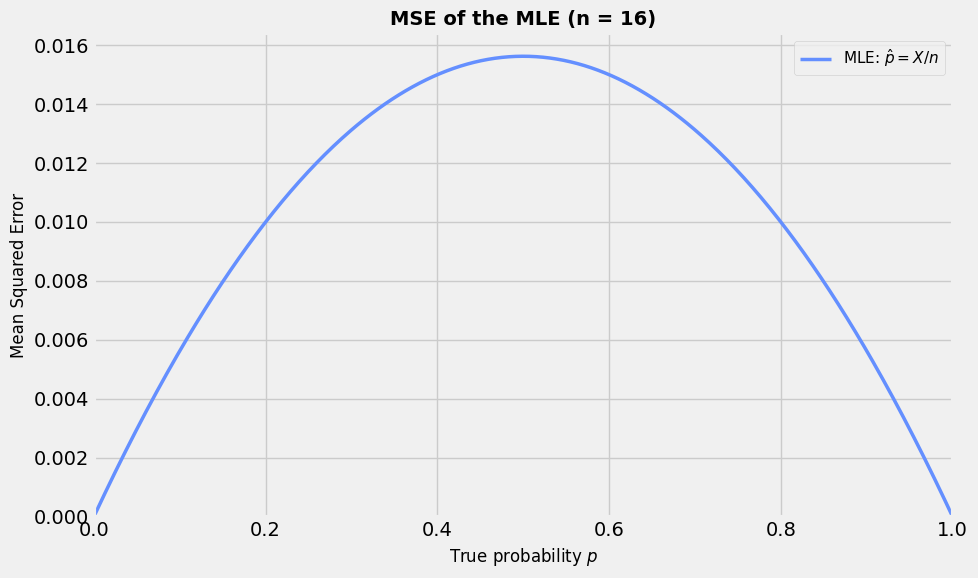

Maximum MSE occurs at p = 0.5: MSE = 0.0156


In [9]:
# Plot the MSE of the MLE
n = 16
p_grid = np.linspace(0.001, 0.999, 500)

# MSE of MLE
mse_mle = p_grid * (1 - p_grid) / n

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(p_grid, mse_mle, color=COLOR_MLE, linewidth=2.5, label=r'MLE: $\hat{p} = X/n$')

ax.set_xlabel('True probability $p$', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12)
ax.set_title(f'MSE of the MLE (n = {n})', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)
ax.set_ylim(0, None)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

print(f"Maximum MSE occurs at p = 0.5: MSE = {0.5 * 0.5 / n:.4f}")

### Returning to the Coin Flip

For the coin example specifically, consider $n = 16$ flips. If we observe $X = 12$ heads, the MLE says $\hat{p} = 12/16 = 0.75$.

Do we really believe the coin has a 75% chance of heads? Most real coins are close to fair. If we had some prior belief that $p$ is likely near 0.5, we might want to **shrink** our estimate toward 0.5.

The MLE is the best *unbiased* estimator. **But who said we have to be unbiased?**

---

## 3. Shrinkage Estimators

### Laplace's Estimator: Adding Pseudodata

**Intuition:** If we think extreme values of $p$ (near 0 or 1) are unlikely, maybe we should shrink our estimate toward 1/2.

**Laplace's idea (1774):** Pretend we observed two extra flips before seeing the data — one head and one tail. This gives:

$$\tilde{p}_1 = \frac{X + 1}{n + 2}$$

For our example with $n = 16$, $X = 12$:
- MLE: $\hat{p} = 12/16 = 0.75$
- Laplace: $\tilde{p}_1 = 13/18 \approx 0.722$

The Laplace estimator shrinks toward 0.5.

### More Aggressive Shrinkage

What if we add *two* heads and *two* tails of pseudodata?

$$\tilde{p}_2 = \frac{X + 2}{n + 4}$$

For $n = 16$, $X = 12$:
- Laplace +2/+2: $\tilde{p}_2 = 14/20 = 0.70$

This shrinks even more toward 0.5.

### A Bootstrap Estimator

Here's another idea: what if we use the bootstrap to improve our estimate?

**Bootstrap procedure:**
1. From the original $n$ Bernoulli observations, draw $B$ bootstrap samples (each of size $n$, with replacement)
2. Compute the MLE $\hat{p}^{(b)} = X^{(b)}/n$ for each bootstrap sample
3. Average them: $\hat{p}_{\text{boot}} = \frac{1}{B} \sum_{b=1}^{B} \hat{p}^{(b)}$

This might seem like a clever way to reduce variance — after all, the bootstrap is useful for quantifying uncertainty. But does averaging bootstrap estimates actually improve the original estimate?

**Spoiler:** It doesn't! The bootstrap estimator has the same bias as the MLE (zero) but *higher* variance. We'll see why.

Let's see how all four estimators compare.

In [ ]:
# Define MSE functions for all four estimators
def mse_mle(p, n):
    """MSE of MLE: X/n"""
    return p * (1 - p) / n

def mse_laplace1(p, n):
    """MSE of Laplace +1/+1: (X+1)/(n+2)"""
    # E[(X+1)/(n+2)] = (np + 1)/(n+2)
    # Bias = (np + 1)/(n+2) - p = (1 - 2p)/(n+2)
    # Var = n * p(1-p) / (n+2)^2
    bias = (1 - 2*p) / (n + 2)
    var = n * p * (1 - p) / (n + 2)**2
    return bias**2 + var

def mse_laplace2(p, n):
    """MSE of Laplace +2/+2: (X+2)/(n+4)"""
    # E[(X+2)/(n+4)] = (np + 2)/(n+4)
    # Bias = (np + 2)/(n+4) - p = (2 - 4p)/(n+4) = 2(1 - 2p)/(n+4)
    # Var = n * p(1-p) / (n+4)^2
    bias = 2 * (1 - 2*p) / (n + 4)
    var = n * p * (1 - p) / (n + 4)**2
    return bias**2 + var

def mse_bootstrap(p, n, B=20):
    """MSE of bootstrap estimator: average of B bootstrap MLEs
    
    Each bootstrap sample draws n observations with replacement from the 
    original n Bernoullis. If X = sum of originals, then each bootstrap 
    sample has X* ~ Binomial(n, X/n) conditional on X, where X ~ Binomial(n, p).
    
    The bootstrap estimator averages B such bootstrap MLEs.
    Unconditionally: E[X*/n] = E[E[X*/n | X]] = E[X/n] = p (unbiased)
    
    Variance is HIGHER than MLE due to added resampling variability.
    Var(X*/n | X) = (X/n)(1 - X/n)/n
    Var(bootstrap mean | X) = (X/n)(1 - X/n)/(nB)
    
    By law of total variance:
    Var(bootstrap mean) = E[Var(mean | X)] + Var(E[mean | X])
                        = E[p_hat(1 - p_hat)/(nB)] + Var(p_hat)
                        = E[p_hat(1 - p_hat)]/(nB) + p(1-p)/n
    
    E[p_hat(1 - p_hat)] = E[p_hat] - E[p_hat^2] = p - (Var(p_hat) + p^2)
                        = p - p(1-p)/n - p^2 = p(1-p)(1 - 1/n)
    
    So: Var(bootstrap) = p(1-p)(1 - 1/n)/(nB) + p(1-p)/n
                       = p(1-p)/n * [1 + (1 - 1/n)/B]
                       = p(1-p)/n * (1 + (n-1)/(nB))
    """
    # Unbiased, so MSE = Variance
    return p * (1 - p) / n * (1 + (n - 1) / (n * B))

# Compute MSE for all estimators
n = 16
B = 20  # Number of bootstrap samples
p_grid = np.linspace(0.001, 0.999, 500)

mse_vals = {
    'MLE': mse_mle(p_grid, n),
    'Laplace +1/+1': mse_laplace1(p_grid, n),
    'Laplace +2/+2': mse_laplace2(p_grid, n),
    'Bootstrap': mse_bootstrap(p_grid, n, B)
}

# Plot all MSE curves
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(p_grid, mse_vals['MLE'], color=COLOR_MLE, linewidth=2.5, 
        label=r'MLE: $\hat{p} = X/n$')
ax.plot(p_grid, mse_vals['Laplace +1/+1'], color=COLOR_LAPLACE1, linewidth=2.5,
        label=r'Laplace +1/+1: $\tilde{p}_1 = (X+1)/(n+2)$')
ax.plot(p_grid, mse_vals['Laplace +2/+2'], color=COLOR_LAPLACE2, linewidth=2.5,
        label=r'Laplace +2/+2: $\tilde{p}_2 = (X+2)/(n+4)$')
ax.plot(p_grid, mse_vals['Bootstrap'], color=COLOR_BAD, linewidth=2.5, linestyle='--',
        label=f'Bootstrap (B={B})')

ax.set_xlabel('True probability $p$', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12)
ax.set_title(f'MSE Comparison of Four Estimators (n = {n})', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.02)
ax.legend(fontsize=11, loc='upper right')

plt.tight_layout()
plt.show()

### Observations from the Plot

1. **The bootstrap estimator is strictly worse than the MLE everywhere!** Its MSE curve lies entirely above the MLE curve.

2. **The other curves cross.** No single estimator (among MLE, Laplace +1/+1, Laplace +2/+2) is best for all values of $p$.

3. **Near $p = 0.5$**, the Laplace estimators beat the MLE. Their shrinkage toward 0.5 helps when $p$ really is near 0.5.

4. **Near $p = 0$ or $p = 1$**, the MLE beats the Laplace estimators. Shrinking toward 0.5 hurts when the truth is extreme.

To understand *why* these patterns occur, we need to examine the bias-variance tradeoff.

---

## 4. Bias-Variance Calculations and Admissibility

### The Bias-Variance Decomposition

For any estimator $T$ of $\theta$, let $\mu = E_\theta[T]$ be its mean. Then:
$$E_\theta[(T - \theta)^2] = E_\theta[(T - \mu + \mu - \theta)^2] = E_\theta[(T - \mu)^2] + (\mu - \theta)^2$$

The cross term vanishes because $E_\theta[T - \mu] = 0$. So:

$$\text{MSE}_\theta(T) = \text{Var}_\theta(T) + \text{Bias}_\theta(T)^2$$

where $\text{Bias}_\theta(T) = E_\theta[T] - \theta$.

### MLE: $\hat{p} = X/n$

The MLE is unbiased, so its MSE equals its variance:
$$\text{MSE}_p(\hat{p}) = \text{Var}_p(\hat{p}) = \frac{p(1-p)}{n}$$

### General Laplace Estimator: $\tilde{p}_k = (X+k)/(n+2k)$

Consider adding $2k$ pseudoflips: $k$ heads and $k$ tails. This gives the estimator:
$$\tilde{p}_k = \frac{X + k}{n + 2k}$$

**Bias:**
$$E_p[\tilde{p}_k] = \frac{np + k}{n + 2k}, \qquad \text{Bias}_p(\tilde{p}_k) = \frac{np + k}{n + 2k} - p = \frac{k(1 - 2p)}{n + 2k}$$

The bias is positive when $p < 0.5$ and negative when $p > 0.5$: the estimator **shrinks toward 0.5**.

**Variance:**
$$\text{Var}_p(\tilde{p}_k) = \frac{np(1-p)}{(n + 2k)^2}$$

Note that the variance is **smaller** than the MLE's variance because the denominator is larger.

**MSE:**
$$\text{MSE}_p(\tilde{p}_k) = \frac{k^2(1-2p)^2 + np(1-p)}{(n+2k)^2}$$

For $k=1$: Laplace +1/+1. For $k=2$: Laplace +2/+2.

### Bootstrap Estimator

The bootstrap estimator averages $B$ bootstrap MLEs, where each bootstrap sample resamples the original $n$ Bernoulli observations with replacement.

**Key insight:** Conditional on the original data (with MLE $\hat{p} = X/n$), each bootstrap sample has $X^* \sim \text{Binomial}(n, \hat{p})$.

**Bias:** The bootstrap estimator is unbiased! 
$$E[\hat{p}_{\text{boot}}] = E[E[\hat{p}_{\text{boot}} | X]] = E[\hat{p}] = p$$

**Variance:** By the law of total variance:
$$\text{Var}(\hat{p}_{\text{boot}}) = E[\text{Var}(\hat{p}_{\text{boot}} | X)] + \text{Var}(E[\hat{p}_{\text{boot}} | X])$$

The second term is just $\text{Var}(\hat{p}) = p(1-p)/n$. The first term adds extra variance from resampling:
$$\text{Var}(\hat{p}_{\text{boot}}) = \frac{p(1-p)}{n} \cdot \left(1 + \frac{n-1}{nB}\right) > \frac{p(1-p)}{n}$$

The bootstrap estimator has **the same bias** as the MLE (zero) but **higher variance**. Its MSE is strictly larger than the MLE's for all $p \ne 0, 1$.

In [ ]:
# Summary table of bias, variance, MSE formulas
print("Summary of Estimator Properties")
print("=" * 85)
print(f"{'Estimator':<25} {'Bias':^20} {'Variance':^25} {'MSE':^20}")
print("-" * 85)
print(f"{'MLE: X/n':<25} {'0':^20} {'p(1-p)/n':^25} {'p(1-p)/n':^20}")
print(f"{'Laplace +1: (X+1)/(n+2)':<25} {'(1-2p)/(n+2)':^20} {'np(1-p)/(n+2)²':^25} {'[formula]':^20}")
print(f"{'Laplace +2: (X+2)/(n+4)':<25} {'2(1-2p)/(n+4)':^20} {'np(1-p)/(n+4)²':^25} {'[formula]':^20}")
print(f"{'Bootstrap (B samples)':<25} {'0':^20} {'> p(1-p)/n':^25} {'> p(1-p)/n':^20}")
print("=" * 85)

### What Went Wrong with the Bootstrap Estimator?

The bootstrap estimator has:
- **Same bias** as the MLE (zero)
- **Higher variance** — the resampling process adds variability

It adds variance without any compensating bias reduction toward a likely value. That's a bad trade!

**The lesson:** Bootstrap is great for *quantifying* uncertainty (e.g., computing confidence intervals), but averaging bootstrap estimates doesn't *reduce* uncertainty. The bootstrap can only simulate the sampling distribution; it can't improve on the original estimator.

The Laplace estimators, by contrast, make a **smart trade**:
- They add bias (toward 0.5)
- But they reduce variance (by inflating the denominator)
- When $p$ is near 0.5, the bias is small and the variance reduction helps
- When $p$ is near 0 or 1, the bias penalty outweighs the variance benefit

### Admissibility

**Definition:** An estimator $T_1$ is **inadmissible** if there exists another estimator $T_2$ such that:
- $R(\theta; T_2) \le R(\theta; T_1)$ for all $\theta \in \Theta$
- $R(\theta; T_2) < R(\theta; T_1)$ for at least one $\theta$

In this case, we say $T_2$ **dominates** $T_1$. An estimator that is not inadmissible is called **admissible**.

**Our estimators:**
- The **bootstrap estimator is inadmissible** — it is dominated by the MLE
- The **MLE, Laplace +1/+1, and Laplace +2/+2 are all admissible** — none dominates another

Admissibility is a minimal requirement: we should never use an inadmissible estimator. But among admissible estimators, we still need a way to choose.

---

## 5. Optimality Criteria

### The Fundamental Problem

We have multiple admissible estimators. How do we choose among them?

**Question:** Is it possible to find an estimator that's best for *all* values of $p$?

**Answer:** No! (At least not for MSE.)

**Why not?** Think about it: if $p = 0.75$ is really the truth, then the constant estimator $T(X) \equiv 0.75$ has MSE = 0 at that point. No other estimator can beat it there. But that constant estimator would be terrible if $p = 0.25$.

No estimator can beat every other estimator at every $p$.

### Two Approaches to Choosing Among Admissible Estimators

**Approach 1: Restrict to a class of estimators**

For example, among **unbiased** estimators, the MLE is optimal.

*Why?* For unbiased estimators, MSE = Variance. So minimizing MSE is the same as minimizing variance. By the Cramér-Rao bound, the MLE achieves the minimum variance among unbiased estimators.

Another example: among **equivariant** estimators (you'll see these in Worksheet 3, Problem 5), there's often a unique best choice.

**Note:** We won't pursue optimality among restricted classes further in this course. Instead, we'll focus on the second approach.

**Approach 2: Summarize the risk function by a single number**

Instead of comparing entire risk curves, we can reduce each estimator to a single number and compare those.

### Worst-Case Risk (Minimax)

Define the **worst-case risk**:
$$R_{\max}(T) = \max_{p \in [0,1]} \text{MSE}_p(T)$$

A **minimax estimator** minimizes the worst-case risk.

This is a conservative approach: we guard against the worst possible scenario.

In [ ]:
# Calculate worst-case risk for each estimator
n = 16
B = 20
p_grid = np.linspace(0.001, 0.999, 1000)

worst_case = {
    'MLE': np.max(mse_mle(p_grid, n)),
    'Laplace +1/+1': np.max(mse_laplace1(p_grid, n)),
    'Laplace +2/+2': np.max(mse_laplace2(p_grid, n)),
    'Bootstrap': np.max(mse_bootstrap(p_grid, n, B))
}

print("Worst-Case Risk (Maximum MSE over all p)")
print("=" * 50)
for name, wc in worst_case.items():
    print(f"{name:<20}: {wc:.6f}")
print("=" * 50)
print(f"\nMinimax estimator: Laplace +2/+2 (smallest worst-case risk)")

For $n = 16$, the **Laplace +2/+2 estimator** $\tilde{p}_2 = (X+2)/(n+4)$ is the minimax estimator!

Its MSE curve is relatively flat, with its maximum at $p = 0.5$. By shrinking toward the center, it avoids extremely bad performance anywhere.

### Average-Case Risk

Instead of worst-case, we could consider **average-case** risk:
$$R_{\text{avg}}(T) = \int_0^1 \text{MSE}_p(T) \, dp$$

This averages the MSE uniformly over all possible values of $p$.

**Question:** We've considered worst-case and average-case risk. Why not **best-case** risk?

**Answer:** Every estimator can achieve arbitrarily small best-case risk — just find some $p$ where it happens to do well (e.g., the constant estimator $T \equiv c$ has MSE = 0 at $p = c$). Best-case risk doesn't discriminate between estimators, so it's not useful.

Which estimator minimizes average-case risk? Let's find out.

---

## 6. Minimizing Average-Case Risk: A Surprising Answer

### The Problem

We want to find the estimator $T(X)$ that minimizes:
$$R_{\text{avg}}(T) = \int_0^1 \text{MSE}_p(T) \, dp = \int_0^1 E_p[(T(X) - p)^2] \, dp$$

### Rewriting the Objective

Let's rewrite the integral as an expectation:
$$R_{\text{avg}}(T) = \int_0^1 E_p[(T(X) - p)^2] \, dp = E\left[(T(X) - p)^2\right]$$

where the expectation is over the **joint distribution** of $(X, p)$ with:
- $p \sim \text{Uniform}(0, 1)$
- $X \mid p \sim \text{Binomial}(n, p)$

### Finding the Optimal $T(X)$

For any fixed value of $X = x$, what choice of $T(x)$ minimizes $E[(T(x) - p)^2 \mid X = x]$?

By the same argument we used for the bias-variance decomposition (with $p$ playing the role of the target and $E[p \mid X]$ playing the role of the mean), we have:
$$E[(T(X) - p)^2 \mid X] = \text{Var}(p \mid X) + (E[p \mid X] - T(X))^2$$

The first term doesn't depend on $T$. The second term is minimized (to zero) when $T(X) = E[p \mid X]$.

So the optimal estimator is the **conditional mean**: $T^*(X) = E[p \mid X]$.

### Computing $E[p \mid X]$

We need the conditional distribution of $p$ given $X$.

<details>
<summary><b>Click to expand: Full derivation of the conditional distribution</b></summary>

We compute the conditional distribution using Bayes' rule.

**Joint distribution:**

For $p \in [0, 1]$ and $x \in \{0, 1, \ldots, n\}$:
$$f(x, p) = P(X = x \mid p) \cdot f(p) = \binom{n}{x} p^x (1-p)^{n-x} \cdot 1$$

**Marginal distribution of $X$:**

$$P(X = x) = \int_0^1 \binom{n}{x} p^x (1-p)^{n-x} dp$$

This integral involves the **Beta function**. Recall that:
$$B(a, b) = \int_0^1 p^{a-1}(1-p)^{b-1} dp = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)} = \frac{(a-1)!(b-1)!}{(a+b-1)!}$$

for positive integers $a, b$.

So:
$$P(X = x) = \binom{n}{x} \int_0^1 p^x (1-p)^{n-x} dp = \binom{n}{x} B(x+1, n-x+1)$$

$$= \binom{n}{x} \frac{x!(n-x)!}{(n+1)!} = \frac{n!}{x!(n-x)!} \cdot \frac{x!(n-x)!}{(n+1)!} = \frac{1}{n+1}$$

**Interesting!** Under a uniform prior on $p$, the marginal distribution of $X$ is uniform on $\{0, 1, \ldots, n\}$.

**Conditional distribution of $p$ given $X$:**

$$f(p \mid x) = \frac{f(x, p)}{P(X = x)} = \frac{\binom{n}{x} p^x (1-p)^{n-x}}{1/(n+1)} = (n+1)\binom{n}{x} p^x (1-p)^{n-x}$$

This is proportional to $p^x (1-p)^{n-x}$, which is the kernel of a **Beta distribution**:
$$p \mid X = x \sim \text{Beta}(x+1, n-x+1)$$

**Conditional mean:**

The mean of a $\text{Beta}(\alpha, \beta)$ distribution is $\frac{\alpha}{\alpha + \beta}$.

So:
$$E[p \mid X] = \frac{X + 1}{(X+1) + (n-X+1)} = \frac{X + 1}{n + 2}$$

</details>

### The Punchline

The estimator that minimizes average-case risk $\int_0^1 \text{MSE}_p(T) \, dp$ is:

$$T^*(X) = E[p \mid X] = \frac{X + 1}{n + 2}$$

**This is exactly Laplace's estimator $\tilde{p}_1$!**

Laplace's "add one head and one tail" rule, which seemed like an intuitive hack, is actually the *optimal* estimator if we measure quality by average MSE over $p \in [0, 1]$.

### The Bayesian Interpretation

What we just computed has a name: it's the **posterior mean** of $p$ given $X$.

- The distribution $p \sim \text{Uniform}(0, 1)$ is called the **prior distribution** — it represents our beliefs about $p$ before seeing data
- The distribution $p \mid X \sim \text{Beta}(X+1, n-X+1)$ is called the **posterior distribution** — it represents our updated beliefs after seeing data
- The posterior mean $E[p \mid X]$ is the **Bayes estimator** for squared error loss

You've already seen Beta-Binomial conjugacy in your probability class — this is the same calculation! The uniform distribution $\text{Uniform}(0,1)$ is the same as $\text{Beta}(1, 1)$, and after observing $X$ successes in $n$ trials, the posterior is $\text{Beta}(1 + X, 1 + n - X) = \text{Beta}(X+1, n-X+1)$.

**An estimator that minimizes average risk (with respect to some prior distribution) is called a Bayes estimator.**

### What About $\tilde{p}_2$?

The Laplace +2/+2 estimator $\tilde{p}_2 = (X+2)/(n+4)$ is also a Bayes estimator — for the **Beta(2, 2) prior** instead of the uniform prior.

The Beta(2,2) prior puts more weight near $p = 0.5$ and less weight near the extremes. If we believe $p$ is likely to be moderate, this prior (and its corresponding Bayes estimator) makes sense.

**Different priors lead to different Bayes estimators, each optimal for its own average-case criterion.**

In [ ]:
# Calculate average-case risk for each estimator
from scipy import integrate

n = 16
B = 20

# Average risk = integral of MSE over p from 0 to 1
avg_risk_mle, _ = integrate.quad(lambda p: mse_mle(p, n), 0, 1)
avg_risk_lap1, _ = integrate.quad(lambda p: mse_laplace1(p, n), 0, 1)
avg_risk_lap2, _ = integrate.quad(lambda p: mse_laplace2(p, n), 0, 1)
avg_risk_boot, _ = integrate.quad(lambda p: mse_bootstrap(p, n, B), 0, 1)

print("Average-Case Risk (Mean MSE over uniform p)")
print("=" * 50)
print(f"{'MLE':<20}: {avg_risk_mle:.6f}")
print(f"{'Laplace +1/+1':<20}: {avg_risk_lap1:.6f}  <-- Minimum!")
print(f"{'Laplace +2/+2':<20}: {avg_risk_lap2:.6f}")
print(f"{'Bootstrap':<20}: {avg_risk_boot:.6f}")
print("=" * 50)
print(f"\nLaplace +1/+1 minimizes average-case risk (it's the Bayes estimator for uniform prior)")

---

## Simulation: Sampling Distributions of the Estimators

Let's visualize how the different estimators behave by simulating their sampling distributions for a specific true value of $p$.

In [ ]:
# Simulate sampling distributions for different true values of p
np.random.seed(42)

n = 16
n_sims = 10000
true_p_values = [0.3, 0.5, 0.7]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, true_p in zip(axes, true_p_values):
    # Simulate X ~ Binomial(n, true_p)
    X = np.random.binomial(n, true_p, size=n_sims)
    
    # Compute estimates
    est_mle = X / n
    est_lap1 = (X + 1) / (n + 2)
    est_lap2 = (X + 2) / (n + 4)
    
    # Create bins centered at the actual discrete values each estimator can take
    # MLE takes values k/16 for k=0,...,16
    # Laplace +1/+1 takes values k/18 for k=1,...,17
    # Laplace +2/+2 takes values k/20 for k=2,...,18
    
    # For MLE: bins centered at k/16, so edges at (k-0.5)/16 and (k+0.5)/16
    mle_bins = (np.arange(n + 2) - 0.5) / n
    
    # For Laplace +1/+1: bins centered at k/18
    lap1_bins = (np.arange(n + 4) - 0.5) / (n + 2)
    
    # For Laplace +2/+2: bins centered at k/20
    lap2_bins = (np.arange(n + 6) - 0.5) / (n + 4)
    
    # Compute histogram counts
    counts_mle, _ = np.histogram(est_mle, bins=mle_bins, density=True)
    counts_lap1, _ = np.histogram(est_lap1, bins=lap1_bins, density=True)
    counts_lap2, _ = np.histogram(est_lap2, bins=lap2_bins, density=True)
    
    # Plot using stairs
    ax.stairs(counts_mle, mle_bins, color=COLOR_MLE, linewidth=2,
              label=f'MLE (MSE={np.mean((est_mle - true_p)**2):.4f})')
    ax.stairs(counts_lap1, lap1_bins, color=COLOR_LAPLACE1, linewidth=2,
              label=f'+1/+1 (MSE={np.mean((est_lap1 - true_p)**2):.4f})')
    ax.stairs(counts_lap2, lap2_bins, color=COLOR_LAPLACE2, linewidth=2,
              label=f'+2/+2 (MSE={np.mean((est_lap2 - true_p)**2):.4f})')
    
    # Mark true value
    ax.axvline(true_p, color=COLOR_TRUE, linestyle='--', linewidth=2, label=f'True p = {true_p}')
    
    ax.set_xlabel('Estimate', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'True p = {true_p}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.set_xlim(0, 1)

plt.suptitle(f'Sampling Distributions of Estimators (n = {n}, {n_sims:,} simulations)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Observations from the Simulation

- **At $p = 0.5$**: The Laplace estimators have lower MSE than the MLE. Their shrinkage toward 0.5 helps because 0.5 is the truth!

- **At $p = 0.3$ and $p = 0.7$**: The MLE and Laplace estimators are more comparable. The Laplace estimators are biased toward 0.5, which slightly hurts them here.

- **All three admissible estimators** concentrate around the true value, but with different bias-variance tradeoffs.

---

## 7. Summary

### Key Concepts

| Concept | Definition |
|---------|------------|
| **Loss function** | $L(\theta, a)$ — measures how bad estimate $a$ is when truth is $\theta$ |
| **Risk function** | $R(\theta; T) = E_\theta[L(\theta, T(X))]$ — expected loss |
| **MSE** | $E_\theta[(T(X) - \theta)^2] = \text{Bias}^2 + \text{Variance}$ |
| **Admissible** | Not dominated by any other estimator |
| **Minimax** | Minimizes worst-case risk $\max_\theta R(\theta; T)$ |
| **Bayes estimator** | Minimizes average risk $\int R(\theta; T) \pi(\theta) d\theta$ |

### What We Learned

1. **The MLE is not always the best estimator.** It's the best *unbiased* estimator, but biased estimators can have lower MSE.

2. **Shrinkage can help.** The Laplace estimators shrink toward 0.5, trading bias for reduced variance. This helps when the true $p$ is near 0.5.

3. **Admissibility is a minimal requirement.** The bootstrap estimator is inadmissible — strictly dominated by the MLE. But many admissible estimators exist.

4. **Bootstrap doesn't reduce uncertainty.** Averaging bootstrap estimates only adds variance. Bootstrap is useful for *quantifying* uncertainty, not *reducing* it.

5. **No uniformly best estimator exists.** Different estimators win for different values of $p$.

6. **Optimality criteria help us choose:**
   - **Minimax**: Laplace +2/+2 minimizes worst-case risk
   - **Bayes (uniform prior)**: Laplace +1/+1 minimizes average-case risk

7. **The Bayes estimator is the posterior mean.** This is our first glimpse of Bayesian statistics — arrived at through a purely frequentist argument!

### Next Time

In Lecture 7, we'll develop the **Bayesian perspective** more fully:
- Treat $\theta$ as a random variable with a **prior distribution**
- Update to a **posterior distribution** after seeing data
- Understand why the **likelihood** is all that matters (given the prior)
- Explore the asymptotic behavior of the posterior

### Worksheet 3 Preview

Problem 5 explores **scale-equivariant estimation** and proves that unbiased equivariant estimators are always inadmissible — you can always improve by shrinking! This complements today's theme: unbiasedness is not always a virtue.